# USDJPY with DQN

* https://github.com/dogwood008/DeepFX
* http://recruit.gmo.jp/engineer/jisedai/blog/deep-q-learning/
* https://www.slideshare.net/JunichiroKatsuta/deep-qlearningfx

In [1]:
import numpy as np
from matplotlib import pyplot as plt

dukascopyからヒストリカルデータをダウンロードする。
- https://www.dukascopy.com/swiss/english/marketwatch/historical

In [2]:
import pandas as pd
class HistData():
    def __init__(self, date_range=None):
        self.csv_path = 'data/USDJPY_Candlestick_5_m_BID_03.07.2017-08.07.2017.csv'
        f = '%d.%m.%Y %H:%M:%S.%f'
        my_parser = lambda date: pd.datetime.strptime(date, f)
        self.csv_data = pd.read_csv(self.csv_path, index_col=0, parse_dates=True, header=0,
                                   date_parser=my_parser)
        self.date_range = date_range
        self.TARGET = 'Close'

    def set_date_range(self, date_range):
        self.date_range = date_range

    def data(self):
        if self.date_range is None:
            return self.csv_data
        else:
            return self.csv_data[self.date_range]

    def max_value(self):
        return self.data()[[self.TARGET]].max()[self.TARGET]

    def min_value(self):
        return self.data()[[self.TARGET]].min()[self.TARGET]

    def dates(self):
        return self.data().index.values

    def plot(self):
        %matplotlib inline
        self.data()[[self.TARGET]].plot()

    def list(self):
        l = []
        for close in hist.data()[[self.TARGET]].iterrows():
            l.append(close[1][0])
        return l

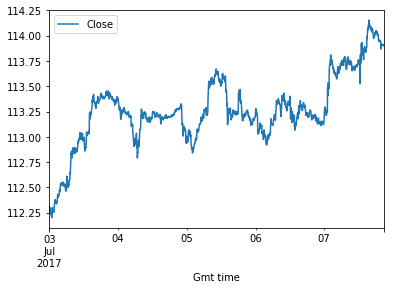

In [3]:
hist = HistData()
hist.plot()


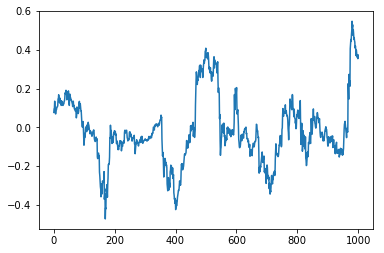

In [4]:
mean = np.mean(hist.list())
hist_list = hist.list() - mean
hist_list = hist_list[200:1200]
len(hist_list)
plt.plot(np.linspace(0,1000, 1000), hist_list)

In [5]:
import enum
class Action(enum.Enum):
    HOLD = 0
    BUY  = 1
    SELL = 2

class Position():
    def __init__(self):
        self.NONE = 0
        self.HOLD = 1
        self.reset()

    def reset(self):
        self.holding = self.NONE
        self.change_action = None
        self.bid = None

    def is_hold(self):
        return self.holding == self.HOLD

    def change(self, action, bid):
        self.bid = bid
        self.holding = self.HOLD
        self.change_action = action

    def close(self, action, bid):
        if action == Action.BUY.value:
            reward = (bid - self.bid) * 10000
        else:
            reward = (self.bid - bid) * 10000
        self.reset()
        return reward

In [6]:
import gym
import gym.spaces

class FXTrade(gym.core.Env):
    def __init__(self, hist_list):
        self.action_space = gym.spaces.Discrete(3) 
        high = np.array([1.0, 1])
        low  = np.array([-1.0, 0])
        self.observation_space = gym.spaces.Box(low=low, high=high) 

        self._position = Position()

        self._hist_list = hist_list
        self._hist_list_len = len(self._hist_list)

        self.cur_id = 0

    def _step(self, action):
        bid = self._hist_list[self.cur_id]
        self.cur_id +=1
        done = True if self.cur_id == self._hist_list_len else False

        if action != Action.HOLD.value and action == self._position.change_action:
            # invalid action ... hold
            action = Action.HOLD.value

        if action == Action.HOLD.value:
            reward = 0
        else:
            if not self._position.is_hold():
                self._position.change(action, bid)
                reward = 0
            else:
                reward = self._position.close(action, bid)
        observation = np.array([bid, self._position.holding])
        return observation, reward, done ,{}

    def _reset(self):
        self.cur_id = 0
        self._position.reset()
        return np.array([self._hist_list[self.cur_id], self._position.holding])

In [7]:
hist_list = hist.list() - np.mean(hist.list())
hist_list = hist_list.tolist()
hist_list = hist_list[200:1200]

# hist_list = []
# for t in np.linspace(0, 192, 1404):
#      hist_list.append(np.sin(t))

env = FXTrade(hist_list)
env.reset()

array([ 0.07676282,  0.        ])

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

Using TensorFlow backend.


In [9]:
nb_actions = env.action_space.n

model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                48        
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_2 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_3 (Activation)    (None, 16)                0         
__________

In [10]:
memory = SequentialMemory(limit=50000, window_length=1)
policy = BoltzmannQPolicy()
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory,
               target_model_update=1e-2, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

In [11]:
dqn.fit(env, nb_steps=10000, visualize=False, verbose=1)

Training for 10000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 68s - reward: 8.4310    
done, took 68.029 seconds


In [12]:
dqn.test(env, nb_episodes=5, visualize=False)

Testing for 5 episodes ...
Episode 1: reward: 28360.000, steps: 1000
Episode 2: reward: 28360.000, steps: 1000
Episode 3: reward: 28360.000, steps: 1000
Episode 4: reward: 28360.000, steps: 1000
Episode 5: reward: 28360.000, steps: 1000
